In [1]:
import sys
import pandas as pd
import fasttext
from collections import defaultdict
import re
from matplotlib import pyplot as plt
import networkx as nx

In [2]:
sys.path.append('../code/')

In [3]:
from training_data_handler import TrainingDataHandler

class LanguageIdentification:
    '''From: https://medium.com/@c.chaitanya/language-identification-in-python-using-fasttext-60359dc30ed0'''

    def __init__(self):
        pretrained_lang_model = "../models/lid.176.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text):
        predictions = self.model.predict(text, k=2)  # returns top 2 matching languages
        return re.sub('__label__', '', predictions[0][0])

/Users/vetonmatoshi/opt/anaconda3/envs/bfh/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
li = LanguageIdentification()

In [5]:
tdh = TrainingDataHandler()

In [6]:
def create_barplot(labels_counted, title='', return_table=False, figsize=(20, 15), width=2.2):
    
    '''
    labels_counted must be a dictionary like this: {'de': 68505, 'fr': 68387, 'it': 68281}
    '''

    plot_data = pd.DataFrame([labels_counted])
    plot_data = plot_data.sort_values(by=0, ascending=False, axis=1)

    if return_table:
        return plot_data
    else:
        ax = plot_data.plot.bar(figsize=figsize, width=width, title=title)
        for container in ax.containers:
            ax.bar_label(container)

In [7]:
def creat_network(dataframe, label_list, iterations=50):

    edge_list = defaultdict(int)

    for i in dataframe.index.tolist():
        dataframe_filtered = dataframe.loc[i].to_dict()
        for k, v in dataframe_filtered.items():
            if v == 1:
                for l in label_list:
                    if l != k:
                        if dataframe_filtered[l]==1:
                            entry = sorted((k,l))
                            entry = ';'.join(entry)
                            edge_list[entry]+=1
    edge_list = [k.split(';')+[v] for k,v in edge_list.items()]
    
    plt.rcParams["figure.figsize"] = (20,20)
    
    G = nx.Graph()

    G.add_weighted_edges_from(edge_list)
    pos=nx.spring_layout(G,seed=42, iterations=iterations)
    nx.draw(G, pos, with_labels=True, font_weight='bold')
    edge_weight = nx.get_edge_attributes(G,'weight')
    edge_weight_as_list = [v/100 for v in edge_weight.values()]
    edge_colors_as_list = ['green' for v in edge_weight.values()]
    #nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight, width = edge_weight)
    nx.draw(G, 
            pos, 
            width = edge_weight_as_list, 
            edge_color=edge_colors_as_list,
            node_color='green',
            font_size=20
           )

    plt.show()

- Raw training data

## 1. The fields

- One of the tasks is to look which text input fields suffice for good predictions
- The important text fields can be in German, Italien or French  and are 
  - `affair_attachment_category`: This field describes the type of the text. It can belong to one of these categories: 
    - `Titel`:  Titel des Geschäfts
    - `Text 1`: Erst eingereichter Vorstoss oder Vorlage (können auch mehrere pro Geschäft sein
    - `Text 2`: Dies ist in der Regel die Antwort oder Reaktion auf den Vorstoss oder die Vorlage
    - `Text 3`: Weitere Dokumente es Geschäfts. In ZH beispielsweise Abstimmungsresultate
- In addition to that, we have the field `language` which can be de, fr, it. This field is important to filter the entries by language
- The dataframe contains the original fields, which are not used 

- All columns
- Not all of them are important for text classification

In [19]:
language = 'all'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], affair_attachment_category='all', merge_texts=True)

In [16]:
len(list(tdh.label2id.keys()))

37

In [15]:
'; '.join(list(tdh.label2id.keys()))

'Alter; Bildung; Forschung; Strategien im Gesundheitssystem; Europapolitik; Kind und Jugend; Medizinische Versorgung; Qualität im Gesundheitswesen; Gesundheitsförderung und Prävention; Sucht-Substanzen; Armut; Soziale Frage; Gesundheit; Familie ; Pflege; Migration und Asyl; Integration ; Medien und Kommunikation; Digitalisierung; Konsum; NPO-Management; Energie; Finanzwesen; Internationale Politik; Kultur; Raumplanung und Wohnungswesen; Sicherheit; Sozialer Schutz; Umwelt; Verkehr; Grundversorgung; Politisches System; Beschäftigung und Arbeit; Landwirtschaft; Recht allgemein; Wirtschaft; Diverses'

## 2. Check if everything is all right

In [9]:
affairs = pd.read_excel('/Users/vetonmatoshi/Documents/Git/LEXTREME/politmonitor/data/Data/affairs.xlsx')
affairs.head()

/Users/vetonmatoshi/opt/anaconda3/envs/politmonitor/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,affair_scope,affair_srcid,affair_key,affair_closed,affair_date_staged,affair_date_updated,affair_deposit_date,affair_deposit_legislativeperiod,affair_deposit_session,affair_state_id,...,person_party_harmonized_de,person_party_harmonized_short_fr,person_party_harmonized_fr,person_party_harmonized_short_it,person_party_harmonized_it,affair_topic_codes,affair_topic_amount,affair_topic_de,affair_topic_fr,affair_topic_it
0,ag,418844.0,09.219,False,NaT,2022-04-14,2009-08-18,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ag,419014.0,10.162,False,NaT,2022-04-14,2010-06-22,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ag,419032.0,10.180,False,NaT,2022-04-14,2010-06-22,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ag,419109.0,10.261,False,NaT,2022-04-14,2010-09-14,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ag,419162.0,10.323,False,NaT,2022-04-14,2010-11-30,NaN,NaN,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- We will check if the topic labels per affair srcid are equal in all dataframes
- We will take the affair_srcid from `affairs` and filter the training data by this affair_srcid
- The field `affair_topic_codes` in the training data and `affairs` should be equal in both cases
- The field `affair_topic_codes_as_labels` in the training data should be equal to `affair_topic_de` in affairs
- **Caution** : The field `affair_topic_de` in affairs.xlsx does not always have all topics!

In [13]:
miss_match = list()
for item in affairs.to_dict(orient='records'):
    affair_srcid = item['affair_srcid'] 
    affair_topic_codes = set(str(item['affair_topic_codes']).split(';'))
    affair_topic_de = set(str(item['affair_topic_de']).split(';'))
    
    # Filter training data
    res = tdh.training_data_df[tdh.training_data_df.affair_text_srcid==affair_srcid]
    if res.shape[0]>0:
        affair_topic_codes_found = res.affair_topic_codes.tolist()[0]
        affair_topic_codes_found = set(affair_topic_codes_found)
        if not affair_topic_codes_found==affair_topic_codes:
            print(affair_srcid)
            miss_match.append(affair_topic_codes_found)
        affair_topic_codes_as_labels_found = res.affair_topic_codes_as_labels.tolist()[0]
        affair_topic_codes_as_labels_found = set(affair_topic_codes_as_labels_found)
        if not affair_topic_codes_as_labels_found==affair_topic_de:
            print(affair_srcid)
            print('Actual value:', affair_topic_de, affair_topic_codes)
            print('Found value:', affair_topic_codes_as_labels_found, affair_topic_codes_found)
            print('#############################')
            miss_match.append(affair_topic_codes_as_labels_found)
            
    

20150037.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20150061.0
Actual value: {'Verkehr'} {'272', '44'}
Found value: {'Gesundheit', 'Verkehr'} {'272', '44'}
#############################
20160029.0
Actual value: {'Recht allgemein'} {'44', '416'}
Found value: {'Gesundheit', 'Recht allgemein'} {'44', '416'}
#############################
20160058.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20170049.0
Actual value: {'Politisches System'} {'356', '44'}
Found value: {'Gesundheit', 'Politisches System'} {'356', '44'}
#############################
20180050.0
Actual value: {'Finanzwesen'} {'44', '264'}
Found value: {'Gesundheit', 'Finanzwesen'} {'44', '264'}
#############################
20180052.0
Actual value: {'Soziale Frage', 'Beschäftigung und Arbeit'} {'44', '366

20143462.0
Actual value: {'nan'} {'44'}
Found value: {'Gesundheit'} {'44'}
#############################
20143663.0
Actual value: {'Recht allgemein'} {'44', '416'}
Found value: {'Gesundheit', 'Recht allgemein'} {'44', '416'}
#############################
20143751.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20153380.0
Actual value: {'Internationale Politik', 'Landwirtschaft'} {'44', '396', '265'}
Found value: {'Gesundheit', 'Internationale Politik', 'Landwirtschaft'} {'44', '396', '265'}
#############################
20163263.0
Actual value: {'Recht allgemein'} {'44', '416'}
Found value: {'Gesundheit', 'Recht allgemein'} {'44', '416'}
#############################
20163790.0
Actual value: {'Sozialer Schutz'} {'44', '270'}
Found value: {'Gesundheit', 'Sozialer Schutz'} {'44', '270'}
#############################
20173271.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '3

20170472.0
Actual value: {'Recht allgemein', 'Migration und Asyl'} {'44', '243', '416'}
Found value: {'Recht allgemein', 'Gesundheit', 'Migration und Asyl'} {'44', '243', '416'}
#############################
20144099.0
Actual value: {'Sozialer Schutz', 'Beschäftigung und Arbeit'} {'44', '366', '270'}
Found value: {'Beschäftigung und Arbeit', 'Gesundheit', 'Sozialer Schutz'} {'44', '366', '270'}
#############################
20163273.0
Actual value: {'Politisches System', 'Landwirtschaft'} {'356', '396', '44'}
Found value: {'Gesundheit', 'Politisches System', 'Landwirtschaft'} {'356', '396', '44'}
#############################
20154159.0
Actual value: {'Wirtschaft'} {'44', '646'}
Found value: {'Wirtschaft', 'Gesundheit'} {'44', '646'}
#############################
20173126.0
Actual value: {'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366'}
Found value: {'Gesundheit', 'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366'}
#############################


20200486.0
Actual value: {'Soziale Frage', 'Wirtschaft', 'Politisches System'} {'356', '43', '646', '44'}
Found value: {'Soziale Frage', 'Gesundheit', 'Politisches System', 'Wirtschaft'} {'356', '43', '646', '44'}
#############################
20204541.0
Actual value: {'Wirtschaft', 'Digitalisierung', 'Sozialer Schutz'} {'250', '646', '44', '270'}
Found value: {'Wirtschaft', 'Gesundheit', 'Digitalisierung', 'Sozialer Schutz'} {'250', '646', '44', '270'}
#############################
20204542.0
Actual value: {'Umwelt'} {'44', '271'}
Found value: {'Umwelt', 'Gesundheit'} {'44', '271'}
#############################
20203046.0
Actual value: {'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366'}
Found value: {'Gesundheit', 'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366'}
#############################
20203431.0
Actual value: {'Sozialer Schutz'} {'44', '270'}
Found value: {'Gesundheit', 'Sozialer Schutz'} {'44', '270'}
#############################
2021

20153078.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20203308.0
Actual value: {'Familie ', 'Politisches System', 'Digitalisierung'} {'250', '46', '44', '356'}
Found value: {'Familie ', 'Gesundheit', 'Politisches System', 'Digitalisierung'} {'250', '46', '44', '356'}
#############################
20213799.0
Actual value: {'Soziale Frage', 'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366', '43'}
Found value: {'Soziale Frage', 'Gesundheit', 'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366', '43'}
#############################
20205005.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20205997.0
Actual value: {'Internationale Politik', 'Beschäftigung und Arbeit'} {'44', '366', '265'}
Found value: {'Gesundheit', 'Internationale Pol

20194400.0
Actual value: {'Politisches System'} {'356', '44'}
Found value: {'Gesundheit', 'Politisches System'} {'356', '44'}
#############################
20200415.0
Actual value: {'Wirtschaft', 'Digitalisierung'} {'250', '44', '646'}
Found value: {'Wirtschaft', 'Gesundheit', 'Digitalisierung'} {'250', '44', '646'}
#############################
20203941.0
Actual value: {'Grundversorgung', 'Beschäftigung und Arbeit'} {'366', '273', '44'}
Found value: {'Gesundheit', 'Grundversorgung', 'Beschäftigung und Arbeit'} {'366', '273', '44'}
#############################
20203960.0
Actual value: {'Beschäftigung und Arbeit', 'Raumplanung und Wohnungswesen'} {'44', '366', '268'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit', 'Raumplanung und Wohnungswesen'} {'44', '366', '268'}
#############################
20160423.0
Actual value: {'nan'} {'44'}
Found value: {'Gesundheit'} {'44'}
#############################
20173162.0
Actual value: {'Wirtschaft'} {'44', '646'}
Found value: {'Wirtschaft

20174233.0
Actual value: {'Verkehr', 'Digitalisierung', 'Beschäftigung und Arbeit'} {'250', '272', '44', '366'}
Found value: {'Beschäftigung und Arbeit', 'Gesundheit', 'Digitalisierung', 'Verkehr'} {'250', '272', '44', '366'}
#############################
20194317.0
Actual value: {'Familie ', 'Bildung', 'Sozialer Schutz'} {'44', '46', '270', '2'}
Found value: {'Familie ', 'Gesundheit', 'Bildung', 'Sozialer Schutz'} {'44', '46', '270', '2'}
#############################
20174197.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20183662.0
Actual value: {'Recht allgemein'} {'44', '416'}
Found value: {'Gesundheit', 'Recht allgemein'} {'44', '416'}
#############################
20143628.0
Actual value: {'nan'} {'46'}
Found value: {'Familie '} {'46'}
#############################
20203811.0
Actual value: {'Sozialer Schutz'} {'44', '270'}
Found value: {'Gesundheit', 'Sozialer Schutz'}

20214428.0
Actual value: {'Wirtschaft', 'Sozialer Schutz'} {'44', '646', '270'}
Found value: {'Wirtschaft', 'Gesundheit', 'Sozialer Schutz'} {'44', '646', '270'}
#############################
20153785.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20174198.0
Actual value: {'Internationale Politik', 'Beschäftigung und Arbeit'} {'44', '366', '265'}
Found value: {'Gesundheit', 'Internationale Politik', 'Beschäftigung und Arbeit'} {'44', '366', '265'}
#############################
20153692.0
Actual value: {'Politisches System'} {'356', '44'}
Found value: {'Gesundheit', 'Politisches System'} {'356', '44'}
#############################
20203472.0
Actual value: {'Recht allgemein', 'Migration und Asyl'} {'44', '243', '416'}
Found value: {'Recht allgemein', 'Gesundheit', 'Migration und Asyl'} {'44', '243', '416'}
#############################
20204595.0
Actual value: {'Soziale Frage',

20163043.0
Actual value: {'Recht allgemein', 'Internationale Politik'} {'416', '44', '265'}
Found value: {'Gesundheit', 'Recht allgemein', 'Internationale Politik'} {'416', '44', '265'}
#############################
20193690.0
Actual value: {'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366'}
Found value: {'Gesundheit', 'Migration und Asyl', 'Beschäftigung und Arbeit'} {'44', '243', '366'}
#############################
20151088.0
Actual value: {'Recht allgemein', 'Internationale Politik'} {'416', '44', '265'}
Found value: {'Gesundheit', 'Recht allgemein', 'Internationale Politik'} {'416', '44', '265'}
#############################
20204649.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20203782.0
Actual value: {'Kind und Jugend', 'Beschäftigung und Arbeit'} {'44', '11', '366'}
Found value: {'Kind und Jugend', 'Gesundheit', 'Beschäftigung und Arbeit'} {'44',

20163145.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20204571.0
Actual value: {'Politisches System'} {'356', '44'}
Found value: {'Gesundheit', 'Politisches System'} {'356', '44'}
#############################
20143906.0
Actual value: {'Wirtschaft', 'Beschäftigung und Arbeit'} {'44', '366', '646'}
Found value: {'Wirtschaft', 'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366', '646'}
#############################
20153554.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20153914.0
Actual value: {'Internationale Politik'} {'44', '265'}
Found value: {'Gesundheit', 'Internationale Politik'} {'44', '265'}
#############################
20203423.0
Actual value: {'Familie ', 'Sozialer Schutz', 'Soziale Frage'} {'44', '46', '43', '270'}
Found value: {'Soziale Frage', 'Ge

20163995.0
Actual value: {'Wirtschaft'} {'44', '646'}
Found value: {'Wirtschaft', 'Gesundheit'} {'44', '646'}
#############################
20143740.0
Actual value: {'Soziale Frage', 'Wirtschaft'} {'44', '43', '646'}
Found value: {'Soziale Frage', 'Wirtschaft', 'Gesundheit'} {'44', '43', '646'}
#############################
20163448.0
Actual value: {'Politisches System'} {'356', '44'}
Found value: {'Gesundheit', 'Politisches System'} {'356', '44'}
#############################
20144120.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20163654.0
Actual value: {'Verkehr'} {'272', '44'}
Found value: {'Gesundheit', 'Verkehr'} {'272', '44'}
#############################
20203569.0
Actual value: {'Recht allgemein', 'Politisches System', 'Medien und Kommunikation'} {'249', '44', '416', '356'}
Found value: {'Recht allgemein', 'Gesundheit', 'Politisches System', 'Medien und Kommunikatio

20223680.0
Actual value: {'Politisches System'} {'356', '44'}
Found value: {'Gesundheit', 'Politisches System'} {'356', '44'}
#############################
20214388.0
Actual value: {'Politisches System', 'Medizinische Versorgung'} {'16', '44', '356'}
Found value: {'Gesundheit', 'Politisches System', 'Medizinische Versorgung'} {'16', '44', '356'}
#############################
20224011.0
Actual value: {'Sozialer Schutz', 'Medien und Kommunikation'} {'249', '44', '270'}
Found value: {'Gesundheit', 'Sozialer Schutz', 'Medien und Kommunikation'} {'249', '44', '270'}
#############################
20221004.0
Actual value: {'Sozialer Schutz', 'Qualität im Gesundheitswesen', 'Beschäftigung und Arbeit'} {'44', '20', '366', '270'}
Found value: {'Beschäftigung und Arbeit', 'Gesundheit', 'Qualität im Gesundheitswesen', 'Sozialer Schutz'} {'44', '20', '366', '270'}
#############################
20163903.0
Actual value: {'Politisches System'} {'356', '44'}
Found value: {'Gesundheit', 'Politisches Sys

20214665.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und Arbeit'} {'44', '366'}
#############################
20210470.0
Actual value: {'Recht allgemein'} {'44', '416'}
Found value: {'Gesundheit', 'Recht allgemein'} {'44', '416'}
#############################
20214589.0
Actual value: {'Wirtschaft', 'Umwelt'} {'44', '271', '646'}
Found value: {'Wirtschaft', 'Umwelt', 'Gesundheit'} {'44', '271', '646'}
#############################
20214160.0
Actual value: {'Wirtschaft', 'Sozialer Schutz'} {'44', '646', '270'}
Found value: {'Wirtschaft', 'Gesundheit', 'Sozialer Schutz'} {'44', '646', '270'}
#############################
20224551.0
Actual value: {'Politisches System', 'Finanzwesen'} {'356', '264', '44'}
Found value: {'Gesundheit', 'Politisches System', 'Finanzwesen'} {'356', '264', '44'}
#############################
20223827.0
Actual value: {'Beschäftigung und Arbeit'} {'44', '366'}
Found value: {'Gesundheit', 'Beschäftigung und A

20213520.0
Actual value: {'Kind und Jugend', 'Recht allgemein'} {'44', '11', '416'}
Found value: {'Kind und Jugend', 'Gesundheit', 'Recht allgemein'} {'44', '11', '416'}
#############################


- As can be seen above, the mismatches are always between the spelled out labels and not between the code
- The reason is that in the excel file affairs.xlsx the column `affair_topic_de` does not always contain all labels

## 2. Distributions

### 2.1. Per language and text type
- Now, we will see how many texts there are per language and text type

- We tried to have more or less the same amount of training data for each language
- We filtered the training data by `affair_text_srcid` and `language`, i.e. we kept only those `affair_text_srcid` that had German, French and Italian inputs texts
-

In [33]:
for affair_text_srcid in tdh.training_data_df.affair_text_srcid.unique():
    language_count = defaultdict(int)
    for item in tdh.training_data_df[tdh.training_data_df.affair_text_srcid==affair_text_srcid].to_dict(orient="recods"):
        language_count[item['language']]+=1
    if language_count['de'] != language_count['fr'] != language_count['it']:
        print(affair_text_srcid)

/var/folders/w1/wqc21nmn2556z5pqs1_g_5000000gn/T/ipykernel_1617/1749388783.py:3: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  for item in tdh.training_data_df[tdh.training_data_df.affair_text_srcid==affair_text_srcid].to_dict(orient="recods"):


20223036
20124167
20133400
20145192
20203767
20204328
20211004
20163434
20214376
20211077
20204124
20223062
20103636
20094208
20143058
20125365
20153482
20200052
20093582
20204665
20151026
20224274
20103950
20163653
20123704
20094217
20204408
20123985
20163638
20140440


KeyboardInterrupt: 

- Take one example and see what differs
- The example below with `affair_text_srcid` 20223036 shows that there is a missing title for French
- But affairs.xlsx does have a French title *Initiative "Stick to Science" et propos professoraux fribourgeois*


In [52]:
tdh.training_data_df[tdh.training_data_df.affair_text_srcid==20223036][['affair_text_srcid','affair_attachment_category','language','text']].sort_values(['affair_attachment_category', 'language'])

,affair_text_srcid,affair_attachment_category,language,text
188339,20223036,Text 1,de,"Die jüngste Einflusskampagne ""Stick to Science..."
188342,20223036,Text 1,de,"Die jüngste Initiative ""Stick to Science"" hat ..."
188343,20223036,Text 1,fr,"La toute récente initiative "" Stick to science..."
188340,20223036,Text 1,fr,"La toute récente campagne d'influence "" Stick ..."
188344,20223036,Text 1,it,"La recente iniziativa ""Stick to science"" perse..."
188341,20223036,Text 1,it,"La campagna ""Stick to science"" lanciata da un ..."
188345,20223036,Text 2,de,1) Der Bundesrat setzt sich für eine schnellst...
188346,20223036,Text 2,fr,1) Le Conseil fédéral s'engage pour une associ...
188347,20223036,Text 2,it,1) Il Consiglio federale lavora per una rapida...
188348,20223036,Titel,de,"Initiative ""Stick to Science"" und Äusserungen ..."


- As can be seen, the language detector failed to detect French and instead detected English, which is why the text was removed (see the results below)

In [56]:
li.predict_lang('Initiative "Stick to Science" et propos professoraux fribourgeois')

'en'

- Nevertheless, the overall number of text inputs does not differ very much from language to language

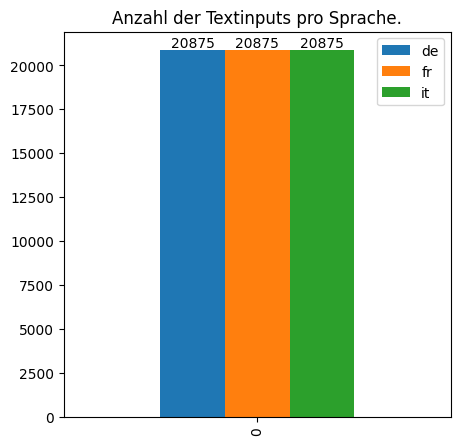

In [22]:
training_data = tdh.training_data_df
#training_data = training_data[['affair_text_srcid', 'language', 'text']]
#training_data = training_data.drop_duplicates(['affair_text_srcid', 'language'])
training_data_df_grouped = training_data[['language', 'text']].groupby(['language']).count()
training_data_df_grouped.to_dict()['text']
create_barplot(training_data_df_grouped.to_dict()['text'],figsize=(5,5),width=0.5, title='Anzahl der Textinputs pro Sprache.')

- Now we look how many inputs there are per text type

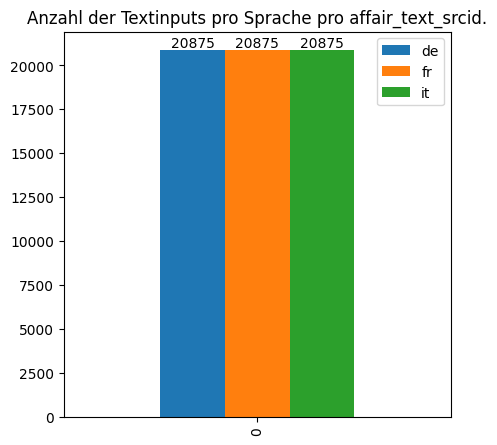

In [89]:
training_data = tdh.training_data_df
training_data = training_data[['affair_text_srcid', 'language', 'text']]
training_data = training_data.drop_duplicates(['affair_text_srcid', 'language'])
training_data_df_grouped = training_data[['language', 'text']].groupby(['language']).count()
training_data_df_grouped.to_dict()['text']
create_barplot(training_data_df_grouped.to_dict()['text'],figsize=(5,5),width=0.5, title='Anzahl der Textinputs pro Sprache pro affair_text_srcid.')

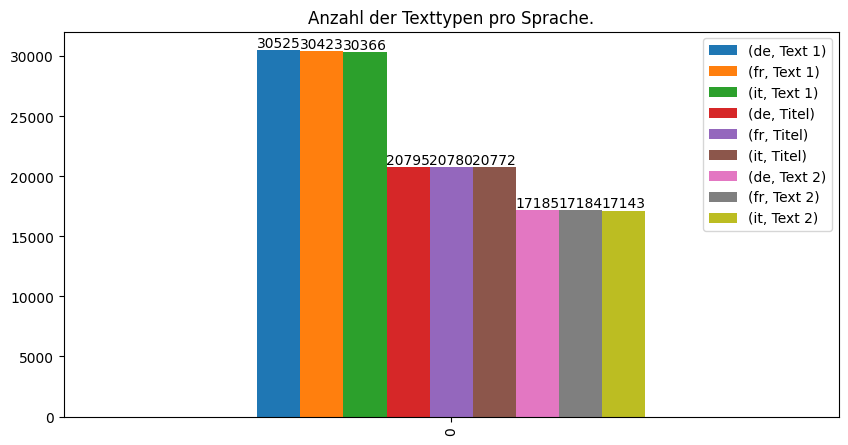

In [97]:
training_data = tdh.training_data_df
training_data_df_grouped = training_data[['text','affair_attachment_category', 'language']].groupby(['language','affair_attachment_category']).count()
create_barplot(training_data_df_grouped.to_dict()['text'],figsize=(10,5),width=0.5, title='Anzahl der Texttypen pro Sprache.')

- Now we look what the mean length of the text inputs is

- Below the histogram for the training data without merged texts

<Axes: title={'center': 'Title'}, ylabel='Frequency'>

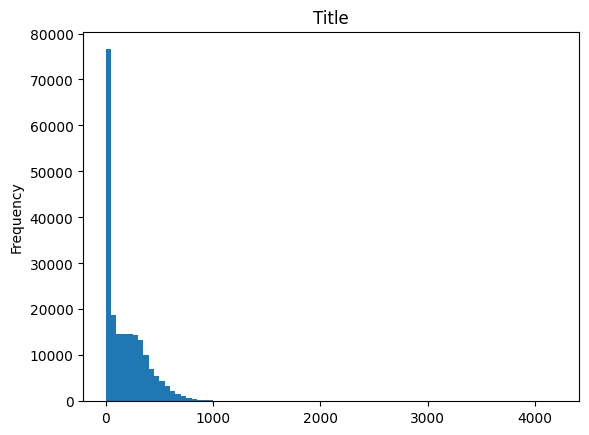

In [104]:
training_data = tdh.training_data_df
# We split the texts by white space
training_data['text_length'] = training_data.text.apply(lambda x: len(x.split()))
bins = [x for x in range(0,training_data['text_length'].max(), 50)]
training_data['text_length'].plot.hist(bins=bins)

- Below the histogram for the training data with merged texts

<AxesSubplot: ylabel='Frequency'>

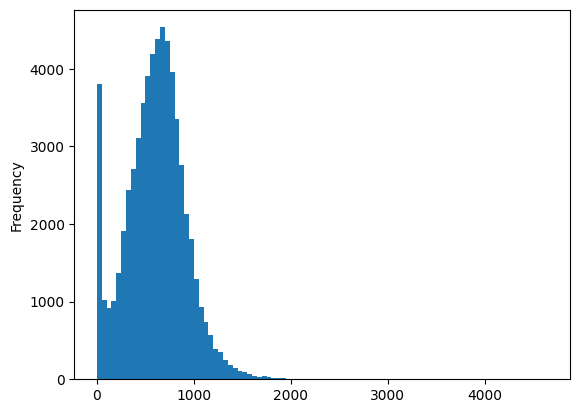

In [59]:
language = 'all'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], affair_attachment_category='all', merge_texts=True)
training_data = tdh.training_data_df
# We split the texts by white space
training_data['text_length'] = training_data.text.apply(lambda x: len(x.split()))
bins = [x for x in range(0,training_data['text_length'].max(), 50)]
training_data['text_length'].plot.hist(bins=bins)


In [60]:
# Rest back to unmerged texts
language = 'all'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], affair_attachment_category='all', merge_texts=False)

/var/folders/w1/wqc21nmn2556z5pqs1_g_5000000gn/T/ipykernel_1617/3256163813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['text_length'] = training_data.text.apply(lambda x: len(x.split()))
/var/folders/w1/wqc21nmn2556z5pqs1_g_5000000gn/T/ipykernel_1617/3256163813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['text_length'] = training_data.text.apply(lambda x: len(x.split()))


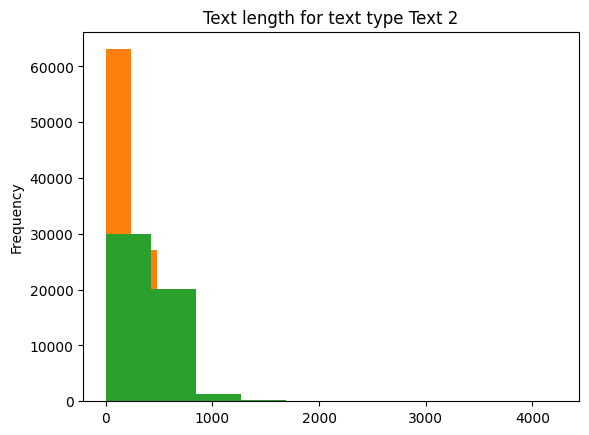

In [108]:
for _input in ['Titel', 'Text 1', 'Text 2']:
    training_data = tdh.training_data_df
    training_data = training_data[training_data.affair_attachment_category==_input]
    # We split the texts by white space
    training_data['text_length'] = training_data.text.apply(lambda x: len(x.split()))
    bins = [x for x in range(0,training_data['text_length'].max(), )]
    training_data['text_length'].plot.hist(title='Text length for text type '+_input)

### 2.2. Labels

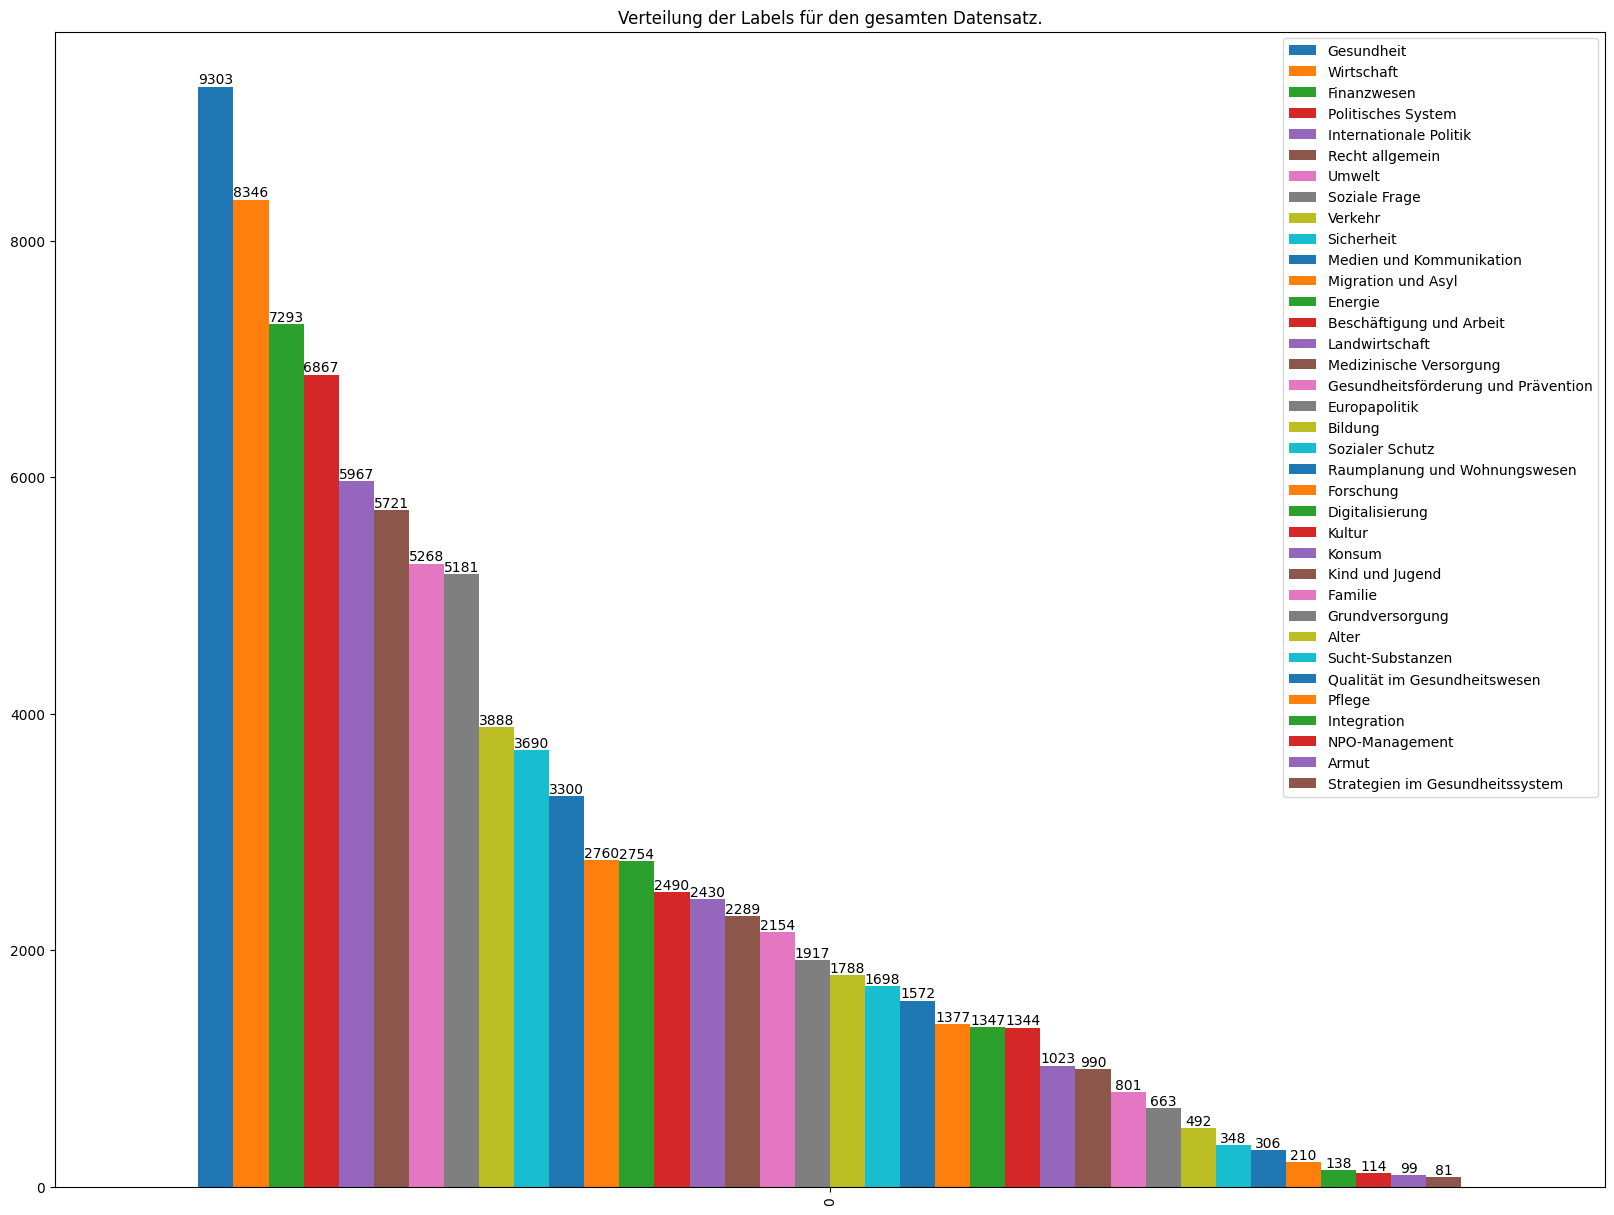

In [24]:
tdh.create_barplot(tdh.training_data_df, title='Verteilung der Labels für den gesamten Datensatz.')

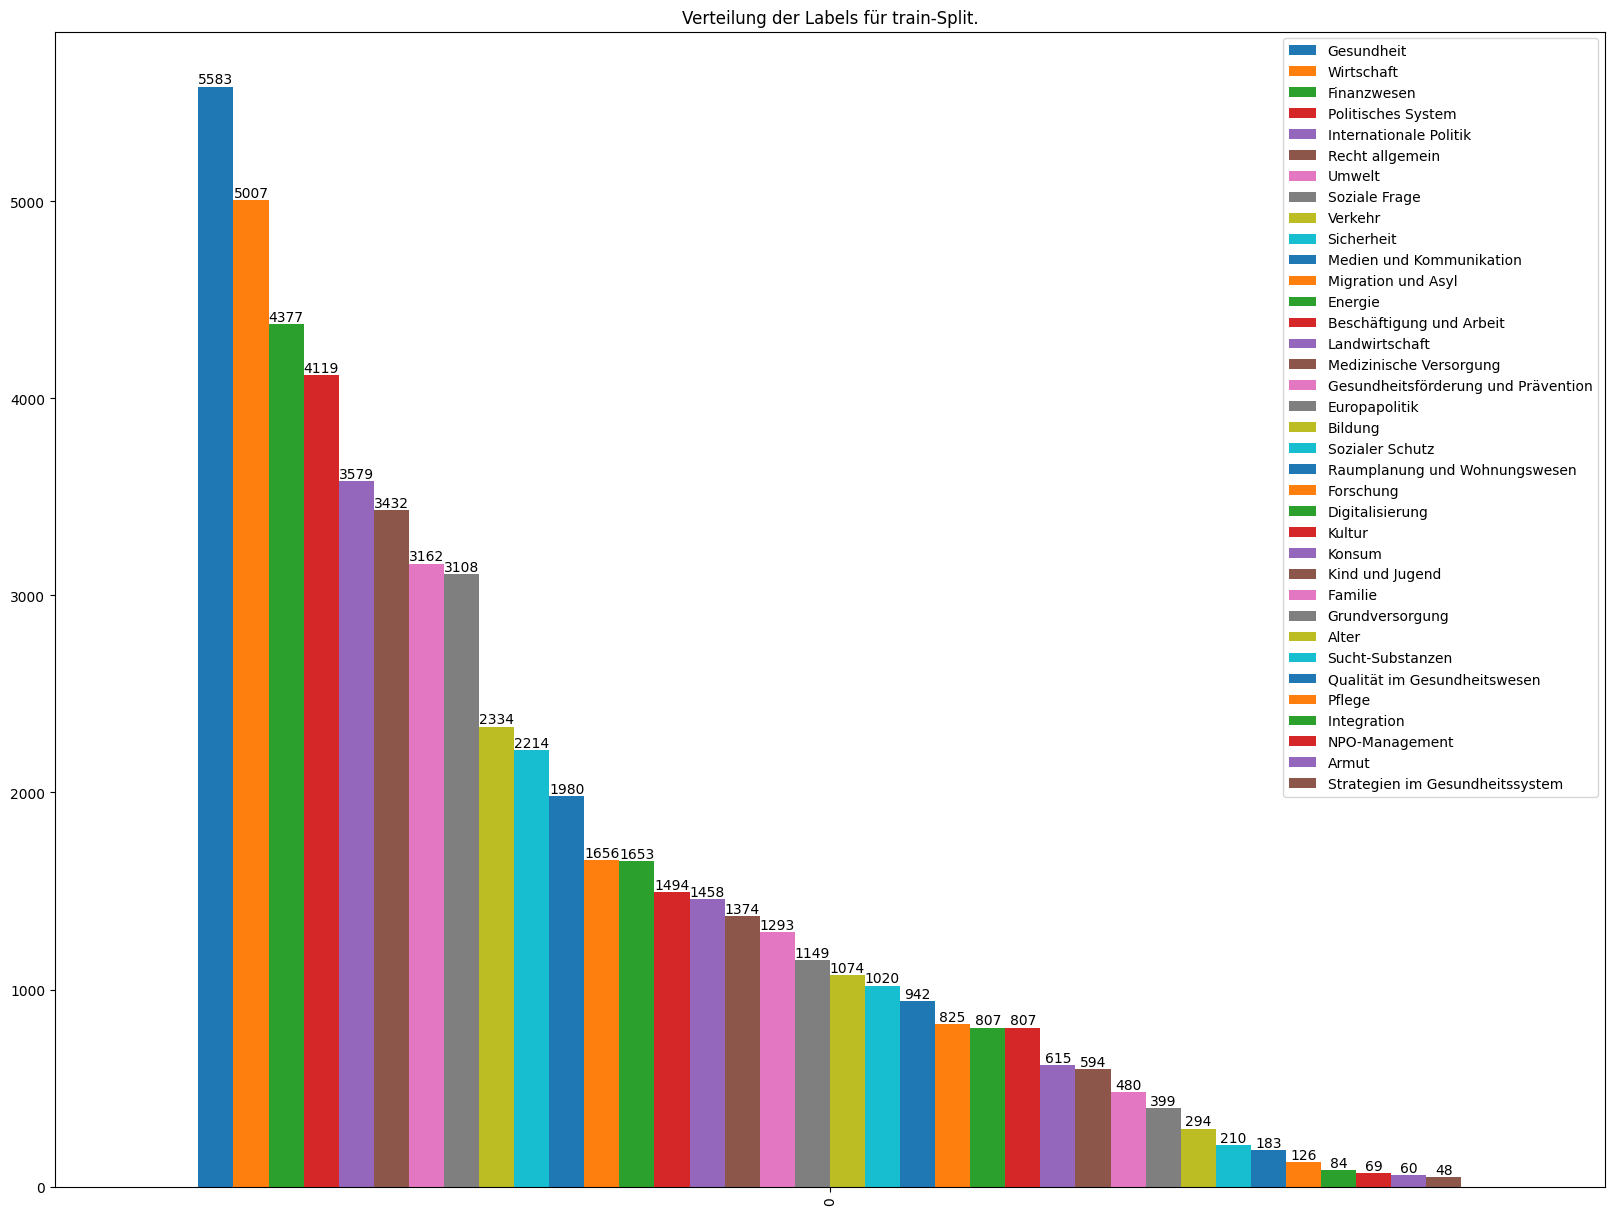

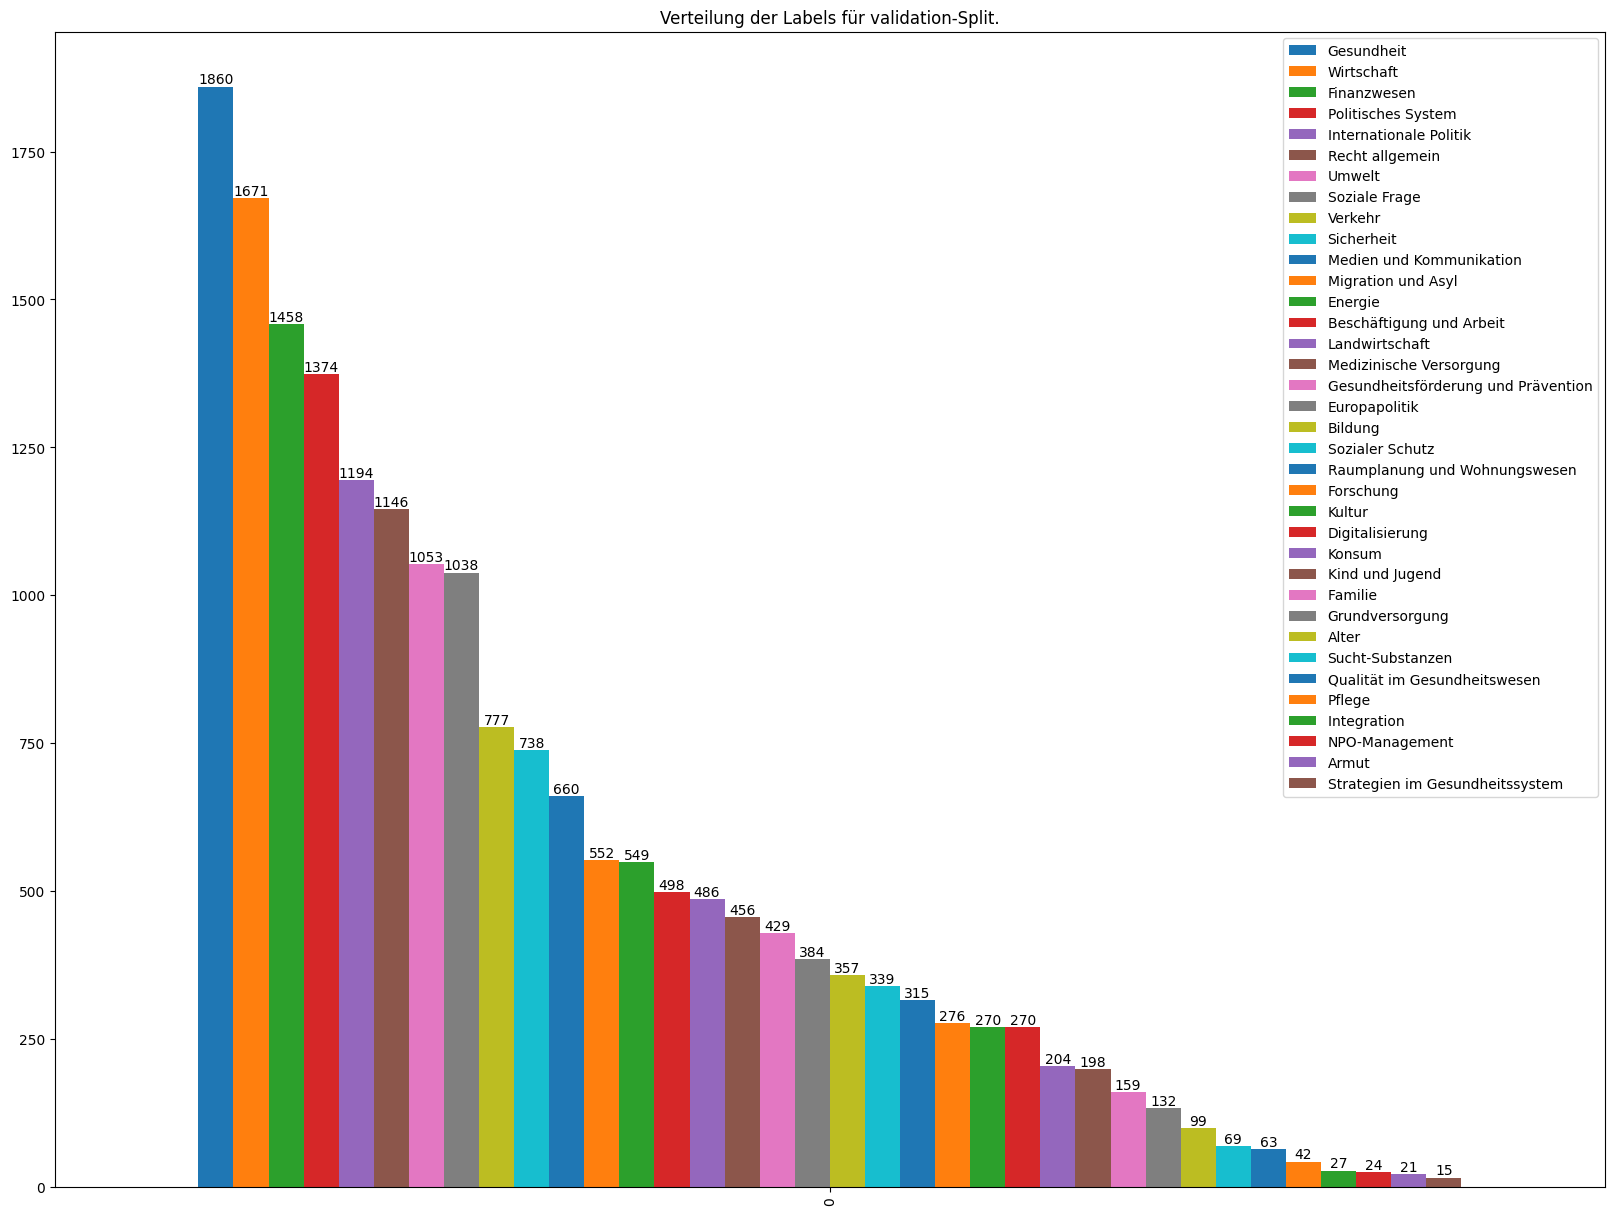

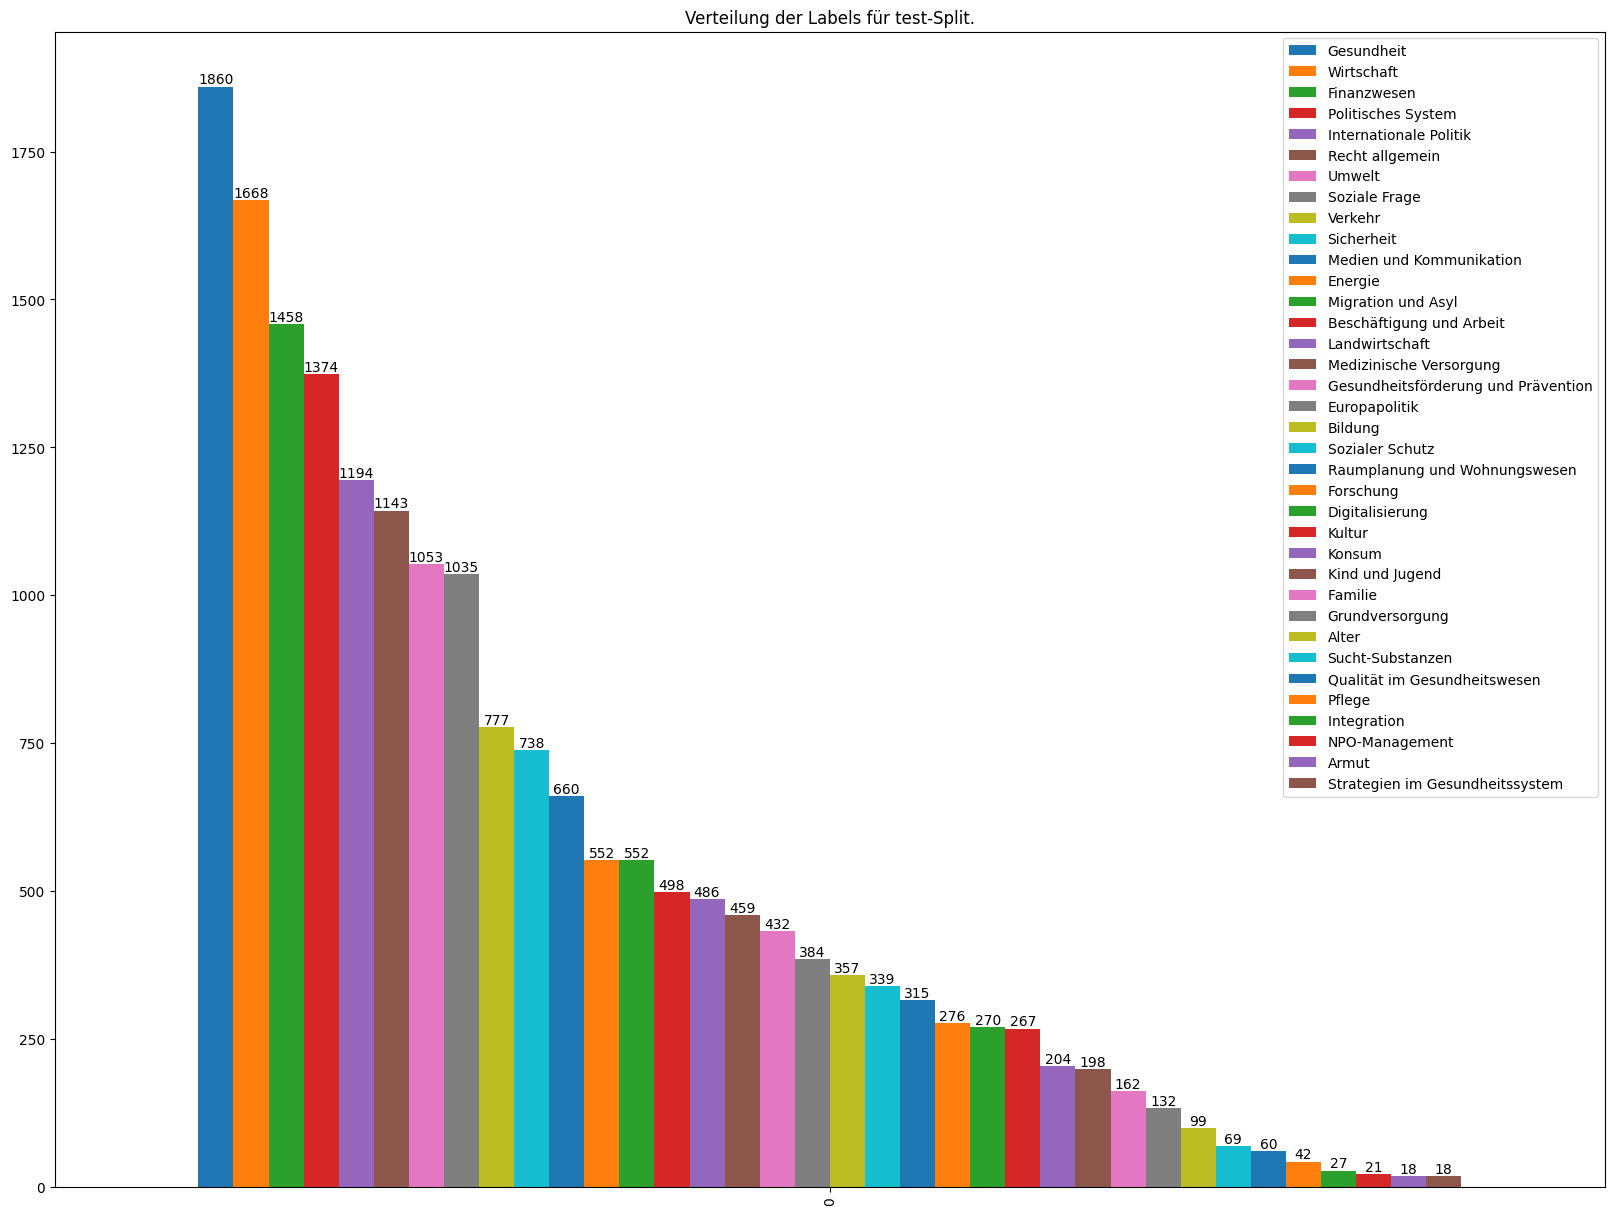

In [25]:
for split in ['train', 'validation', 'test']:
    tdh.create_barplot(tdh.training_data_df, title='Verteilung der Labels für '+split+ '-Split.', split=split)

## 3. Co-occurence analysis

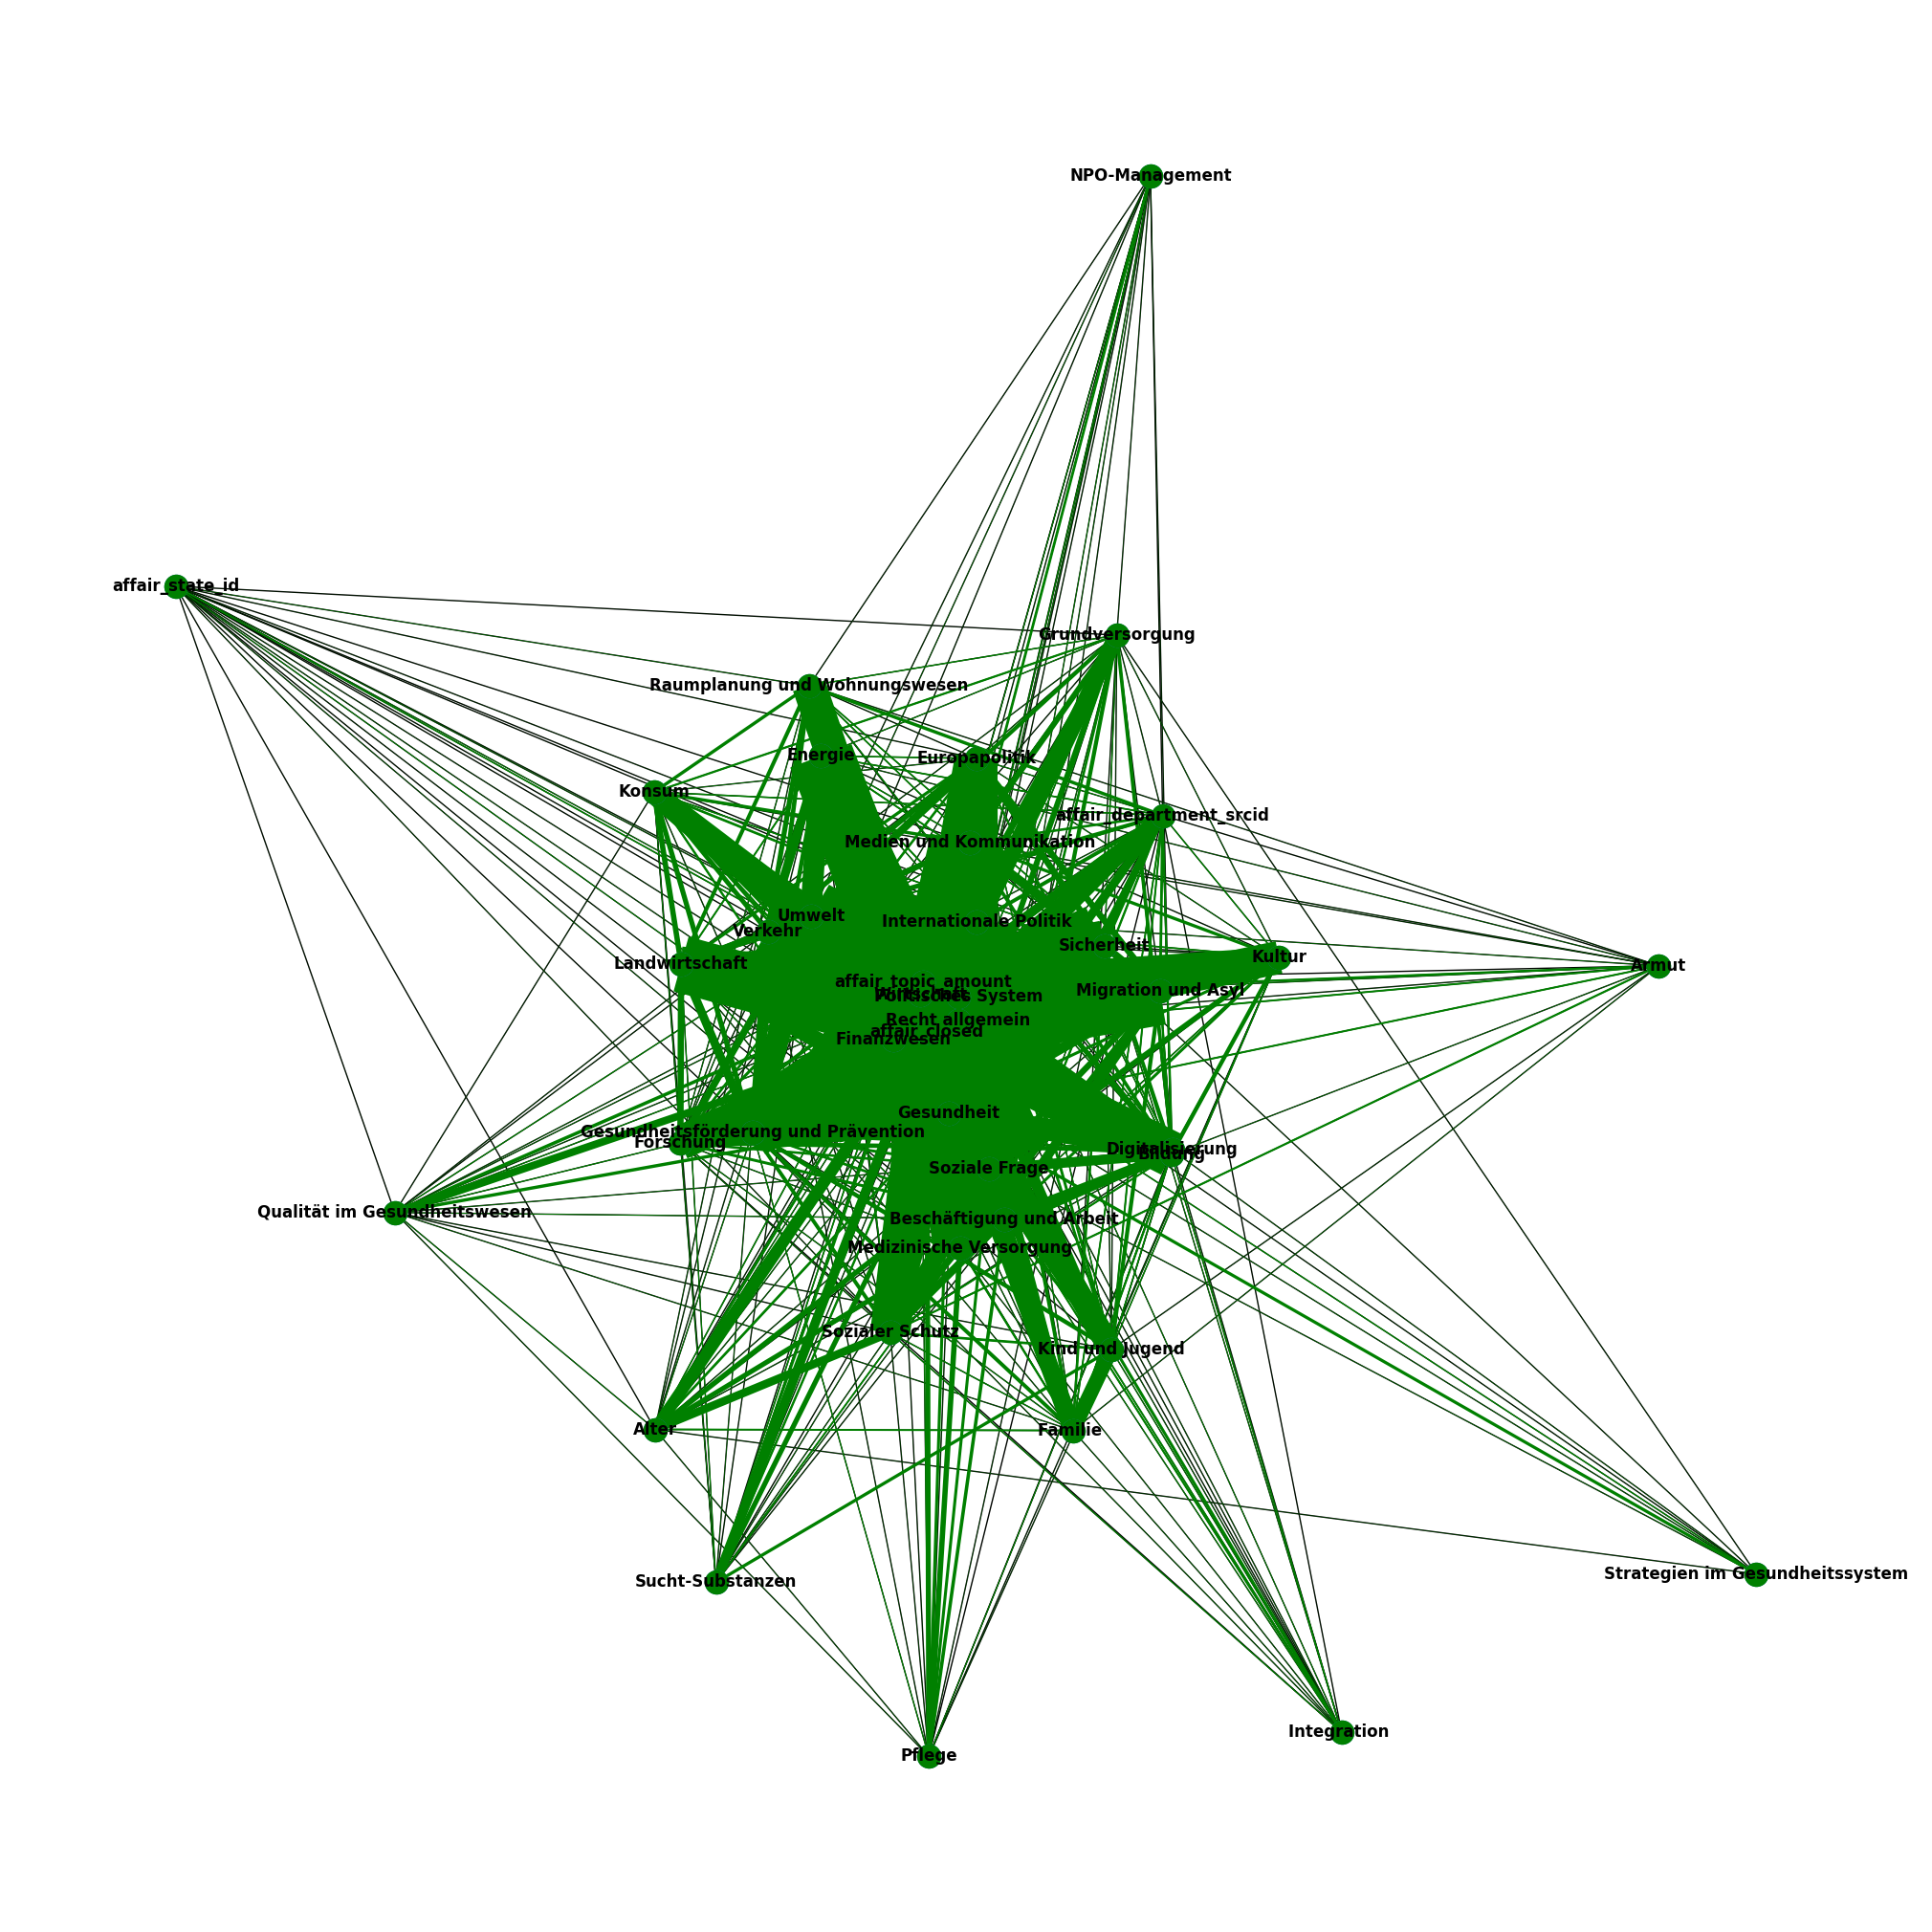

In [23]:
sorted(list(tdh.label2id.keys()))
creat_network(tdh.training_data_df[tdh.training_data_df.split=='train'], label_list=sorted(list(tdh.label2id.keys())), iterations=1000)

In [24]:
def co_occurence_analysis(label_1, label_2, split=None):
    if split is None:
        df = tdh.training_data_df
    else:
        df = tdh.training_data_df[tdh.training_data_df.split==split]
        
    total_number_of_label_1 = df[df[label_1]==1].shape[0]
    total_number_of_label_1_and_2 = df[(df[label_1]==1) & (df[label_2]==1)].shape[0]
    relative_number_of_label_1_and_2 = (100/total_number_of_label_1)*total_number_of_label_1_and_2
    return {'total_number_of_label_1': total_number_of_label_1, 'total_number_of_label_1_and_2': total_number_of_label_1_and_2,'relative_number_of_label_1_and_2':relative_number_of_label_1_and_2 }

    
    

In [25]:
co_occurence_analysis('Gesundheit', 'Strategien im Gesundheitssystem')

{'total_number_of_label_1': 31282,
 'total_number_of_label_1_and_2': 186,
 'relative_number_of_label_1_and_2': 0.5945911386739978}

In [58]:
res = list()
for item in tdh.training_data_df[(tdh.training_data_df.language=='de')].to_dict(orient="records"):
    if 'Gesundheit' in item['affair_topic_codes_as_labels'] and 'Strategien im Gesundheitssystem' in item['affair_topic_codes_as_labels']:
        if len(item['text']) <300:
            entry = dict()
            entry['affair_attachment_category']=item['affair_attachment_category']
            entry['affair_topic_codes_as_labels']=item['affair_topic_codes_as_labels']
            entry['text']=item['text']
            res.append(entry)
            
pd.DataFrame(res).to_excel('cases_with_Gesundheit_and_Strategien_im_Gesundheitssystem.xlsx')

In [59]:
res = list()
for item in tdh.training_data_df[(tdh.training_data_df.language=='de')].to_dict(orient="records"):
    if 'Gesundheit' in item['affair_topic_codes_as_labels'] and 'Strategien im Gesundheitssystem' not in item['affair_topic_codes_as_labels']:
        if len(item['text']) <300:
            entry = dict()
            entry['affair_attachment_category']=item['affair_attachment_category']
            entry['affair_topic_codes_as_labels']=item['affair_topic_codes_as_labels']
            entry['text']=item['text']
            res.append(entry)
            
pd.DataFrame(res).to_excel('cases_with_Gesundheit_and_without_Strategien_im_Gesundheitssystem.xlsx')

In [73]:
import random
scr_id = random.choice(tdh.training_data_df.affair_text_srcid.tolist())

In [75]:
scr_id

20113615

In [87]:
tdh.training_data['train']['affair_text_srcid']

set()

## Filtering

- The filtering is done on the basis of the following fields from `tdh.raw_data_for_training`: `language`, `title`, `text`, `affair_text_scope`
- All of these fields have default values. The default values will choose every available data
- Having default values means that you do not have to specify every field for filtering
- The filtering is done with the following methods:
  - `tdh.get_training_data(languages, affair_text_scope, inputs)`: will return a dataset that can be used for training with the transformers library. The dataset can be accessed via tdh.traing_data
  - `tdh.filter_training_data(languages, affair_text_scope, inputs)`: will return a pandas dataframe
- The following arguments are important:
  - `languages`

In [ ]:
language = 'de'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], text=False)
print('Number of examples for '+language+': ', tdh.training_data_df.shape[0])
print(tdh.training_data_df[['title','language','split']].groupby(['language','split']).count())
for split in ['train', 'validation', 'test']:
    tdh.create_barplot(tdh.training_data_df[tdh.training_data_df.split==split], split)

In [ ]:
language = 'fr'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], text=False)
print('Number of examples for '+language+': ', tdh.training_data_df.shape[0])
print(tdh.training_data_df[['title','language','split']].groupby(['language','split']).count())
for split in ['train', 'validation', 'test']:
    tdh.create_barplot(tdh.training_data_df[tdh.training_data_df.split==split], split)

In [ ]:
language = 'it'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], text=False)
print('Number of examples for '+language+': ', tdh.training_data_df.shape[0])
print(tdh.training_data_df[['title','language','split']].groupby(['language','split']).count())
for split in ['train', 'validation', 'test']:
    tdh.create_barplot(tdh.training_data_df[tdh.training_data_df.split==split], split)

In [ ]:
language = 'de,fr'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], text=False)
print('Number of examples for '+language+': ', tdh.training_data_df.shape[0])
print(tdh.training_data_df[['title','language','split']].groupby(['language','split']).count())
for split in ['train', 'validation', 'test']:
    tdh.create_barplot(tdh.training_data_df[tdh.training_data_df.split==split], split)

In [ ]:
language = 'de,fr,it'
tdh.get_training_data(language=language, affair_text_scope=['zh','ch'], text=False)
print('Number of examples for '+language+': ', tdh.training_data_df.shape[0])
print(tdh.training_data_df[['title','language','split']].groupby(['language','split']).count())
for split in ['train', 'validation', 'test']:
    tdh.create_barplot(tdh.training_data_df[tdh.training_data_df.split==split], split)

In [ ]:
tdh.training_data_df[['text_de','affair_topic_codes_as_labels','split']]

In [ ]:
tdh.filter_training_data(languages='all', affair_text_scope='all', inputs='all')

In [ ]:
tdh.raw_data_for_training.shape


In [ ]:
raw_data_for_training = pd.read_json('../data/raw_data_for_training.jsonl', lines=True)
raw_data_for_training_ch_zh = raw_data_for_training[raw_data_for_training.affair_text_scope.isin(['zh','ch'])]
raw_data_for_training.head()

In [ ]:
raw_data_for_training.columns.tolist()

## 1. Data analysis


In [ ]:
print("The raw training data set has ", raw_data_for_training.shape[0], " examples.")
print("Each affair_text_srcid can have several texts, such as title, Vorstoss etc.")
print("If we count only the unique values of affair_text_srcid we get ", raw_data_for_training.drop_duplicates('affair_text_srcid').shape[0], " examples")
print(raw_data_for_training.drop_duplicates('affair_text_srcid').shape[0], " is the total number of examples we can work with.")
print("If we keep only the data from Zurich and Switzerland (Bund), we have ", raw_data_for_training_ch_zh.drop_duplicates('affair_text_srcid').shape[0], " examples.")


- Counting how often each label occurs
- First we do a simple count: How often does each label occur per text or row

In [ ]:
# Creating overview of the frequency of all labels

def create_barplot(df, title=''):

    all_labels = list()
    for label_list in df.affair_topic_codes_as_labels:
        for label in label_list:
            all_labels.append(label)

    labels_counted = dict(Counter(all_labels))
    labels_counted = dict(sorted([x for x in labels_counted.items()], key=lambda x: x[1], reverse=True))
    #for label, count in labels_counted.items():
        #print(label,': ',count, end=' ; ')
    plot_data = pd.DataFrame([labels_counted]) 
    plot_data = plot_data.sort_values(by=0, ascending=False, axis=1)
    ax = plot_data.plot.bar(figsize = (20,15), width=2.2, title=title)
    for container in ax.containers:
        ax.bar_label(container)
        
create_barplot(raw_data_for_training,'Frequency of each label per text.')

- However, each affair_text_srcid can have several texts, such as title, Vorstoss etc.
- We will keep only uniques rows based on affair_text_srcid and then make a count


In [ ]:
create_barplot(raw_data_for_training.drop_duplicates('affair_text_srcid'),'Frequency of each label per unique affair_text_srcid.')

- In the following alos the same plots for the data filtered by ch and zh


In [ ]:
create_barplot(raw_data_for_training_ch_zh,'Frequency of each label per text only for ch and zh.')
create_barplot(raw_data_for_training_ch_zh.drop_duplicates('affair_text_srcid'),'Frequency of each label per unique affair_text_srcid only for ch and zh.')

- Co-occurence analysis

In [ ]:
corr = data_for_split_df[list(label2id.keys())].corr()
corr.style.background_gradient(cmap='coolwarm')

## 2. Create split


- Next we need to create a train, validation, test split
- According to [this post](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912) this package is good: https://github.com/trent-b/iterative-stratification
- Therefore, I will use this python package: https://github.com/trent-b/iterative-stratification
- The splits will be done only on the unique affair_text_srcid
- We will do the first split only on the basis of the data for *ch* and *zh*


In [ ]:
with open('../utils/label2id.json') as f:
    label2id = js.load(f)


def create_df_for_split(initial_df, colum_for_duplicate_removal='affair_text_srcid'):    
    
    initial_df = initial_df.drop_duplicates(colum_for_duplicate_removal)


    data_for_split = list()

    for r in initial_df.to_dict(orient='records'):
        item = dict()
        affair_text_srcid = r['affair_text_srcid']
        affair_topic_codes_as_labels = r['affair_topic_codes_as_labels']
        affair_topic_codes = r['affair_topic_codes']
        item['affair_text_srcid'] = affair_text_srcid
        item['affair_topic_codes_as_labels'] = affair_topic_codes_as_labels
        item['affair_topic_codes'] = affair_topic_codes

        one_hot_affair_topic_codes = []
        for label in sorted(list(label2id.keys())):
            if label in affair_topic_codes_as_labels:
                item[label]=1
                one_hot_affair_topic_codes.append(1)
            else:
                item[label]=0
                one_hot_affair_topic_codes.append(0)

        item['one_hot_affair_topic_codes'] = one_hot_affair_topic_codes

        data_for_split.append(item)

    data_for_split_df = pd.DataFrame(data_for_split)
    
    data_for_split_df = data_for_split_df.reset_index(drop=True)
    
    return data_for_split_df
    


In [ ]:
create_df_for_split(raw_data_for_training_ch_zh)

In [ ]:
# https://github.com/trent-b/iterative-stratification



X = np.array(['Bla', 'bla', 'bla', 'bla', 'bla', 'bla', 'bla', 'bla'])
y = np.array([[0,0,1], [0,0,0], [1,0,1], [1,0,1], [1,1,1], [0,1,1], [1,0,0], [1,0,0]])



def create_split(dataframe, test_size=0.4):
    
    if 'split' not in dataframe.columns:
        dataframe['split']=''
    
    X = dataframe.affair_text_srcid.values
    y = np.array(dataframe.one_hot_affair_topic_codes.tolist())
    
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

    for train_index, test_index in msss.split(X, y):
        dataframe.loc[(dataframe.index.isin(train_index)), 'split'] = 'train'
        dataframe.loc[(dataframe.index.isin(test_index)), 'split'] = 'other'
        
        dataframe_filtered = dataframe[dataframe.split=='other'].reset_index(drop=False)
        X = dataframe_filtered.affair_text_srcid.values
        y = np.array(dataframe_filtered.one_hot_affair_topic_codes.tolist())
        
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

        for validation_index, test_index in msss.split(X, y):
            for i,_ in dataframe_filtered.iterrows():
                _index = dataframe_filtered.at[i, 'index']
                if i in validation_index:
                    dataframe.at[_index,'split']='validation'
                if i in test_index:
                    dataframe.at[_index,'split']='test'
            
    return dataframe
    


In [ ]:
data_for_split_df = create_df_for_split(raw_data_for_training_ch_zh)

data_for_split_df = create_split(data_for_split_df)
data_for_split_df

In [ ]:
data_for_split_df[['affair_text_srcid', 'split']].groupby('split').count().plot.bar()

- Checking if the labels have an equal distribution over all splits


In [ ]:
for split in ['train', 'validation', 'test']:
    train_affair_text_srcid = data_for_split_df[data_for_split_df.split==split].affair_text_srcid.tolist()
    train_affair_text_srcid = [int(x) for x in train_affair_text_srcid]
    create_barplot(raw_data_for_training_ch_zh_unique[(raw_data_for_training_ch_zh_unique.affair_text_srcid.isin(train_affair_text_srcid))], title=split)

## 3. Train model


In [ ]:
from datasets import Dataset


In [ ]:
Dataset.from_list

In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer, sample_dataset


# Load a dataset from the Hugging Face Hub
# dataset = load_dataset("sst2")



dataset = load_dataset("joelito/lextreme", "covid19_emergency_event")

# Simulate the few-shot regime by sampling 8 examples per class
train_dataset = dataset["train"] #[:20]
eval_dataset = dataset["validation"]
train_dataset = train_dataset.remove_columns('language')
eval_dataset = eval_dataset.remove_columns('language')

# Load a SetFit model from Hub
model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    multi_target_strategy="one-vs-rest",
)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"input": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

# Push model to the Hub
trainer.push_to_hub("my-awesome-setfit-model")

# Download from Hub and run inference
model = SetFitModel.from_pretrained("lewtun/my-awesome-setfit-model")
# Run inference
preds = model(["i loved the spiderman movie!", "pineapple on pizza is the worst 🤮"])

In [ ]:
train_dataset

In [ ]:
sample_dataset?

In [ ]:
train_dataset = sample_dataset(dataset["train"], label_column="label", num_samples=8)

In [ ]:
dataset['train'] #.features['label'].feature.names

## Old Code

In [ ]:
df = pd.read_excel('../data/Data/affairs.xlsx')
#df = df[df.affair_scope=="zh"]
df = df[df.affair_topic_codes.isin(['1696','other'])]
df = df[df.affair_topic_codes.isnull()==False]
df.shape

In [ ]:
label2id = dict()

topic_labels = pd.read_excel('../data/topics_politmonitor.xlsx')

for r in topic_labels.to_dict(orient='records'):
    item = dict()
    label2id[r["keyword_de"]]=int(r['keyword_id'])
    
for label_list in df.affair_topic_codes.tolist():
    for label in label_list:
        if int(label) not in label2id.values():
            label2id[int(label)]='not_specified_label_'+str(label)
    
with open('../data/label2id.json','w') as f:
    js.dump(label2id, f, indent=2, ensure_ascii=False)

In [ ]:
len(label2id.keys())

In [ ]:
def process_topic_codes(affair_topic_codes):
    affair_topic_codes_as_list = affair_topic_codes.split(';')
    affair_topic_codes_as_list = [int(x) for x in affair_topic_codes_as_list if x]
    
    return sorted(affair_topic_codes_as_list)
   
df = df.fillna('')
df["affair_topic_codes"]=df.affair_topic_codes.apply(process_topic_codes)


In [ ]:
df.head()

In [ ]:
dataset = list()
X = df.title_de.to_numpy()
y = df.affair_topic_codes.to_numpy()
for r in df.to_dict(orient="records"):
    if len(r['affair_topic_codes'])>0:
        item = dict()
        item['input']=r['title_de']
        labels_as_string = list()
        for label, _id in label2id.items():
            if _id in r['affair_topic_codes']:
                item[label]=1
                #labels_as_string.append(str(_id))
            else:
                item[label]=0
                #labels_as_string.append(str('None'))
        item['labels_as_string']=';'.join([str(x) for x in r['affair_topic_codes']])
        item['label']=r['affair_topic_codes']
        dataset.append(item)
    
dataset = pd.DataFrame(dataset)
dataset['language']='de'
dataset.head()

frequency_count = Counter(dataset.labels_as_string)

# StratifiedShuffleSplit cannot process labels that occur only once
# Therefore, for all labels that occur only once we give the value other in the field labels_as_string
for i, _ in dataset.iterrows():
    labels_as_string = dataset.at[i, 'labels_as_string']
    if frequency_count[labels_as_string]<5:
        dataset.at[i, 'labels_as_string']='other'

frequency_count = Counter(dataset.labels_as_string)
frequency_count

In [ ]:
from sklearn.model_selection import train_test_split




X = dataset.input
y = dataset.labels_as_string


split_indices = dict()

X_train, X_1, y_train, y_1 = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

split_indices['train']=X_train.index
    
X_validation, X_test, y_validation, y_test = train_test_split(X_1, y_1, test_size=0.5, random_state=42, shuffle=True)
split_indices['validation']=X_validation.index
split_indices['test']=X_test.index

dataset['split']=''
for i, _ in dataset.iterrows():
    if i in split_indices['train']:
        dataset.at[i,'split']='train'
    if i in split_indices['validation']:
        dataset.at[i,'split']='validation'
    if i in split_indices['test']:
        dataset.at[i,'split']='test'
    #else:
        #dataset.at[i,'split']='train'
        

In [ ]:
dataset[['input','split']].groupby('split').count().plot.bar()

In [ ]:
dataset[dataset.split=='train'][['input','labels_as_string']].groupby('labels_as_string').count().plot.bar()

In [ ]:
dataset[dataset.split=='validation'][['input','labels_as_string']].groupby('labels_as_string').count().plot.bar()

In [ ]:
dataset[dataset.split=='test'][['input','labels_as_string']].groupby('labels_as_string').count().plot.bar()

In [ ]:
dataset.to_json('../data/dataset_for_training.jsonl',lines=True, force_ascii=False, orient="records")

In [ ]:
ds = DatasetDict()

for split in ['train','validation','test']:
    x = Dataset.from_pandas(dataset[dataset.split==split][['input','label','language']])
    ds[split] = x

In [ ]:
ds['validation']

In [ ]:
pd.read_json('../data/dataset_for_training.jsonl', lines=True)